# Check gpu

In [2]:
%load_ext autoreload
%autoreload 2


In [3]:
import tensorflow as tf
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
gpus = tf.config.experimental.list_physical_devices('GPU')
gpus

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1147849599286934185
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 17267113832820641690
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 3380539589241003263
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 22681055488
locality {
  bus_id: 1
  links {
  }
}
incarnation: 14405149337656281462
physical_device_desc: "device: 0, name: TITAN RTX, pci bus id: 0000:42:00.0, compute capability: 7.5"
]


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Roberta

# get data

In [5]:
import nest_asyncio
import sys
from green_mood_tracker.twint_class import TWINT
import pandas as pd
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import download
from green_mood_tracker.training_data import get_raw_data_notebook

In [6]:
raw_data = get_raw_data_notebook()

/home/hamish/.virtualenvs/henry2/lib/python3.6/site-packages/green_mood_tracker/training_data.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sentiment140_final['source'] = 'sentiment140'


In [7]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/hamish/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [8]:
from green_mood_tracker.data_cleaning import clean
raw_data = get_raw_data_notebook()
raw_data_clean = clean(raw_data,'text')
raw_data_clean.head()

[nltk_data] Downloading package wordnet to /home/hamish/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
/home/hamish/.virtualenvs/henry2/lib/python3.6/site-packages/green_mood_tracker/training_data.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sentiment140_final['source'] = 'sentiment140'


,id,text,polarity,source
0,1467933112,angel going miss athlete weekend,0,sts_gold
1,2323395086,look though shaq getting traded cleveland play...,0,sts_gold
2,1467968979,april th isnt coming soon enough,0,sts_gold
3,1990283756,drinking mcdonalds coffee understanding someon...,0,sts_gold
4,1988884918,dissapointed taylor swift doesnt twitter,0,sts_gold


In [10]:
raw_data_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1633048 entries, 0 to 1599999
Data columns (total 4 columns):
 #   Column    Non-Null Count    Dtype 
---  ------    --------------    ----- 
 0   id        1633048 non-null  object
 1   text      1633048 non-null  object
 2   polarity  1633048 non-null  int64 
 3   source    1633048 non-null  object
dtypes: int64(1), object(3)
memory usage: 62.3+ MB


2    810317
0    810184
1     12547
Name: polarity, dtype: int64

In [12]:
raw_data_clean = raw_data_clean[raw_data_clean['polarity']!=1]

In [13]:
data_sample = raw_data_clean.sample(n=10_000,random_state=0).reset_index()
data_sample.head()

,index,id,text,polarity,source
0,336834,2014083611,pinch even fought amma hate new goatee sd look...,0,sentiment140
1,622734,2229303528,didnt even get try week,0,sentiment140
2,1016867,1881768019,giving jack quick hair cut,2,sentiment140
3,1090541,1969804803,pirate game sat sun work monday tuesthur work ...,2,sentiment140
4,947493,1823084268,fun night,2,sentiment140


In [14]:
data_sample['polarity'] = data_sample.polarity.map({2:1,0:0})
data_sample.head()

,index,id,text,polarity,source
0,336834,2014083611,pinch even fought amma hate new goatee sd look...,0,sentiment140
1,622734,2229303528,didnt even get try week,0,sentiment140
2,1016867,1881768019,giving jack quick hair cut,1,sentiment140
3,1090541,1969804803,pirate game sat sun work monday tuesthur work ...,1,sentiment140
4,947493,1823084268,fun night,1,sentiment140


In [15]:
data_sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   index     10000 non-null  int64 
 1   id        10000 non-null  object
 2   text      10000 non-null  object
 3   polarity  10000 non-null  int64 
 4   source    10000 non-null  object
dtypes: int64(2), object(3)
memory usage: 390.8+ KB


In [134]:
# data_sample['text'] = data_sample.text.apply((lambda x: x.split()))

In [16]:
from sklearn.model_selection import train_test_split

X = data_sample.text
y = data_sample.polarity

sentence_train, sentence_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state = 0)

In [17]:
sentence_train, sentence_val, y_train, y_val = train_test_split(sentence_train, y_train, test_size=0.3, random_state = 0)

In [18]:
sentence_train

8649    home relax busy day traveling south north euro...
2875                               go work soo sunny fair
5980     wat happened follower bak think im gonna cry grr
7474                                           work later
2070                      dammit im gonna busy work today
                              ...                        
7328    bottle tree park farmparkplayground family har...
5884    happy see bank account successfully saved almo...
7150                                          good answer
4821    lol cuz jessi look like sister made titan squa...
7507                       need knock outnot feeling well
Name: text, Length: 6300, dtype: object

In [106]:
#!pip install absl-py --quiet

In [107]:
#!pip install tensorflow-datasets --quiet

In [108]:
#!pip install transformers --quiet

# build roberta

In [1]:
MAX_LEN=24

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run Add: Dst tensor is not initialized. [Op:Add]

In [19]:
import pandas as pd
# Recommended tensorflow version is <= 2.1.0, otherwise F1 score function breaks
import tensorflow as tf
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
import tensorflow_datasets as tfds
from transformers import TFRobertaForSequenceClassification, TFRobertaModel
from transformers import RobertaTokenizer
import os

In [20]:
import pandas as pd, numpy as np
import tensorflow as tf
import tensorflow.keras.backend as K
from sklearn.model_selection import StratifiedKFold
from transformers import *
import tokenizers
print('TF version',tf.__version__)

TF version 2.3.1


In [138]:
max_length = 100

# the recommended batches size for BERT are 32,64 ... however on this dataset we are overfitting quite fast
# and smaller batches work like a regularization.
# You might play with adding another dropout layer instead.

batch_size = 64

In [21]:
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
tokenizer.save_vocabulary('.')

('./vocab.json', './merges.txt')

In [22]:
MAX_LEN = 96
#PATH = '../input/tf-roberta/'
#tokenizer = tokenizers.ByteLevelBPETokenizer(
#    vocab_file=PATH+'vocab-roberta-base.json', 
#    merges_file=PATH+'merges-roberta-base.txt', 
#   lowercase=True,
#    add_prefix_space=True
#)
sentiment_id = {'positive': 1313, 'negative': 2430}
#train = pd.read_csv('../input/tweet-sentiment-extraction/train.csv').fillna('')
#train.head()

In [140]:
ct = train.shape[0]
input_ids = np.ones((ct,MAX_LEN),dtype='int32')
attention_mask = np.zeros((ct,MAX_LEN),dtype='int32')
token_type_ids = np.zeros((ct,MAX_LEN),dtype='int32')
start_tokens = np.zeros((ct,MAX_LEN),dtype='int32')
end_tokens = np.zeros((ct,MAX_LEN),dtype='int32')

for k in range(train.shape[0]):
    
    # FIND OVERLAP
    text1 = " "+" ".join(train.loc[k,'text'].split())
    text2 = " ".join(train.loc[k,'selected_text'].split())
    idx = text1.find(text2)
    chars = np.zeros((len(text1)))
    chars[idx:idx+len(text2)]=1
    if text1[idx-1]==' ': chars[idx-1] = 1 
    enc = tokenizer.encode(text1) 
        
    # ID_OFFSETS
    offsets = []; idx=0
    for t in enc.ids:
        w = tokenizer.decode([t])
        offsets.append((idx,idx+len(w)))
        idx += len(w)
    
    # START END TOKENS
    toks = []
    for i,(a,b) in enumerate(offsets):
        sm = np.sum(chars[a:b])
        if sm>0: toks.append(i) 
        
    s_tok = sentiment_id[train.loc[k,'sentiment']]
    input_ids[k,:len(enc.ids)+5] = [0] + enc.ids + [2,2] + [s_tok] + [2]
    attention_mask[k,:len(enc.ids)+5] = 1
    if len(toks)>0:
        start_tokens[k,toks[0]+1] = 1
        end_tokens[k,toks[-1]+1] = 1

In [ ]:
test = pd.read_csv('../input/tweet-sentiment-extraction/test.csv').fillna('')

ct = test.shape[0]
input_ids_t = np.ones((ct,MAX_LEN),dtype='int32')
attention_mask_t = np.zeros((ct,MAX_LEN),dtype='int32')
token_type_ids_t = np.zeros((ct,MAX_LEN),dtype='int32')

for k in range(test.shape[0]):
        
    # INPUT_IDS
    text1 = " "+" ".join(test.loc[k,'text'].split())
    enc = tokenizer.encode(text1)                
    s_tok = sentiment_id[test.loc[k,'sentiment']]
    input_ids_t[k,:len(enc.ids)+5] = [0] + enc.ids + [2,2] + [s_tok] + [2]
    attention_mask_t[k,:len(enc.ids)+5] = 1

In [ ]:
def build_model_layers():
    ids = tf.keras.layers.Input((MAX_LEN,), dtype=tf.int32)
    att = tf.keras.layers.Input((MAX_LEN,), dtype=tf.int32)
    tok = tf.keras.layers.Input((MAX_LEN,), dtype=tf.int32)

    config = RobertaConfig.from_pretrained('roberta-base')
    config.save_pretrained('.')
    bert_model = TFRobertaModel.from_pretrained("roberta-base",config=config)
    bert_model.save_weights('pretrained-roberta-base.h5')
    x = bert_model(ids,attention_mask=att,token_type_ids=tok)

    x1 = tf.keras.layers.Conv1D(1,1)(x[0])
    x1 = tf.keras.layers.Flatten()(x1)
    x1 = tf.keras.layers.Activation('sigmoid')(x1)

    x2 = tf.keras.layers.Conv1D(1,1)(x[0])
    x2 = tf.keras.layers.Flatten()(x2)
    x2 = tf.keras.layers.Activation('sigmoid')(x2)

    model = tf.keras.models.Model(inputs=[ids, att, tok], outputs=[x1,x2])
    optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
    model.compile(loss='binary_crossentropy', optimizer=optimizer)

    return model
model = build_model_layers()

In [ ]:
oof_start = np.zeros((input_ids.shape[0],MAX_LEN))
oof_end = np.zeros((input_ids.shape[0],MAX_LEN))
preds_start = np.zeros((input_ids_t.shape[0],MAX_LEN))
preds_end = np.zeros((input_ids_t.shape[0],MAX_LEN))

skf = StratifiedKFold(n_splits=5,shuffle=True,random_state=777)
for fold,(idxT,idxV) in enumerate(skf.split(input_ids,train.sentiment.values)):

    print('#'*25)
    print('### FOLD %i'%(fold+1))
    print('#'*25)
    
    K.clear_session()
    model = build_model()
        
    sv = tf.keras.callbacks.ModelCheckpoint(
        '%s-roberta-%i.h5'%(VER,fold), monitor='val_loss', verbose=1, save_best_only=True,
        save_weights_only=True, mode='auto', save_freq='epoch')
        
    model.fit([input_ids[idxT,], attention_mask[idxT,], token_type_ids[idxT,]], [start_tokens[idxT,], end_tokens[idxT,]], 
        epochs=3, batch_size=32, verbose=DISPLAY, callbacks=[sv],
        validation_data=([input_ids[idxV,],attention_mask[idxV,],token_type_ids[idxV,]], 
        [start_tokens[idxV,], end_tokens[idxV,]]))
    
    print('Loading model...')
    model.load_weights('%s-roberta-%i.h5'%(VER,fold))
    
    print('Predicting OOF...')
    oof_start[idxV,],oof_end[idxV,] = model.predict([input_ids[idxV,],attention_mask[idxV,],token_type_ids[idxV,]],verbose=DISPLAY)
    
    print('Predicting Test...')
    preds = model.predict([input_ids_t,attention_mask_t,token_type_ids_t],verbose=DISPLAY)
    preds_start += preds[0]/skf.n_splits
    preds_end += preds[1]/skf.n_splits
    
    # DISPLAY FOLD JACCARD
    all = []
    for k in idxV:
        a = np.argmax(oof_start[k,])
        b = np.argmax(oof_end[k,])
        if a>b: 
            st = train.loc[k,'text'] # IMPROVE CV/LB with better choice here
        else:
            text1 = " "+" ".join(train.loc[k,'text'].split())
            enc = tokenizer.encode(text1)
            st = tokenizer.decode(enc.ids[a-1:b])
        all.append(jaccard(st,train.loc[k,'selected_text']))
    jac.append(np.mean(all))
    print('>>>> FOLD %i Jaccard ='%(fold+1),np.mean(all))
    print()

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(patience=2,restore_best_weights=True,monitor='val_accuracy')
history = model.fit(ds_train_encoded, epochs=number_of_epochs,
          validation_data=ds_val_encoded, callbacks=[es])

Epoch 1/8
296/296 [==============================] - 161s 544ms/step - loss: 0.5478 - accuracy: 0.7223 - val_loss: 0.5034 - val_accuracy: 0.7656
Epoch 2/8
153/296 [==============>...............] - ETA: 1:07 - loss: 0.4608 - accuracy: 0.7899

In [120]:
def plot_loss(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Mean Square Error - Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='best')
    plt.show()
    
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='best')
    plt.show()

In [121]:
import matplotlib.pyplot as plt
import seaborn as sns

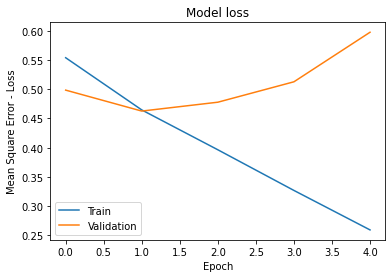

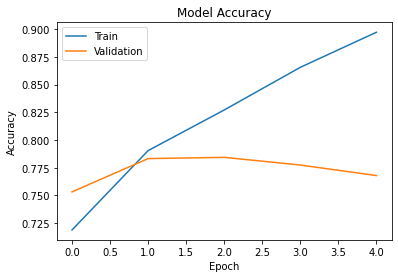

In [122]:
plot_loss(history)

In [123]:
model.evaluate(ds_test_encoded)

47/47 [==============================] - 7s 156ms/step - loss: 0.5019 - accuracy: 0.7830


[0.5018749833106995, 0.7829999923706055]

In [ ]:
import joblib

filename = 'model_w2v_binary.joblib'
joblib.dump(model_w2v, filename)